In [ ]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

# Project A: Knowledge Distillation for Building Lightweight Deep Learning Models in Visual Classification Tasks

In [ ]:
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()
tf.compat.v1.enable_eager_execution()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

In [ ]:
# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)


Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


# Model creation

In [ ]:
#@test {"output": "ignore"}

# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),strides=1, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2),strides = 1),
    tf.keras.layers.Conv2D(64, (3, 3), strides=1,activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2),strides = 2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES)
])


# Build fully connected student.


# your code start from here for step 2
fc_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES),
])



# Teacher loss function

In [ ]:
@tf.function
def compute_teacher_loss(images, labels):
  """Compute subclass knowledge distillation teacher loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  subclass_logits = cnn_model(images, training=True)

  # Compute cross-entropy loss for subclasses.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,subclass_logits))

  return cross_entropy_loss_value

# Student loss function

In [ ]:
#@test {"output": "ignore"}

# Hyperparameters for distillation (need to be tuned).
ALPHA = 0.5 # task balance between cross-entropy and distillation loss
DISTILLATION_TEMPERATURE = 4 #temperature hyperparameter

def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  """Compute distillation loss.

  This function computes cross entropy between softened logits and softened
  targets. The resulting loss is scaled by the squared temperature so that
  the gradient magnitude remains approximately constant as the temperature is
  changed. For reference, see Hinton et al., 2014, "Distilling the knowledge in
  a neural network."

  Args:
    teacher_logits: A Tensor of logits provided by the teacher.
    student_logits: A Tensor of logits provided by the student, of the same
      shape as `teacher_logits`.
    temperature: Temperature to use for distillation.

  Returns:
    A scalar Tensor containing the distillation loss.
  """
 # your code start from here for step 3
  soft_targets = tf.nn.softmax(teacher_logits / temperature, axis=1)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / temperature)) * temperature ** 2

def compute_student_loss(images, labels):
  """Compute subclass knowledge distillation student loss for given images
     and labels.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  student_subclass_logits = fc_model(images, training=True)

  # Compute subclass distillation loss between student subclass logits and
  # softened teacher subclass targets probabilities.

  # your code start from here for step 3

  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits, student_subclass_logits, DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3

  cross_entropy_loss_value = tf.reduce_mean(
        tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=student_subclass_logits))

  total_loss = ALPHA * cross_entropy_loss_value + (1. - ALPHA) * distillation_loss_value

  return total_loss

# Train and evaluation

In [ ]:
@tf.function
def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  class_logits = model(images, training=False)
  return tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(class_logits, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(class_logits, -1), tf.argmax(labels, -1)


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  # your code start from here for step 4
  optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images, labels)

      grads = tape.gradient(loss_value, model.trainable_variables)

      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      # your code start from here for step 4
      correct_predictions, _, _ = compute_num_correct(model, images, labels)
      num_correct += correct_predictions.numpy()

    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
  return num_correct / num_total * 100


# Training models

In [ ]:
# your code start from here for step 5
print("Training the teacher model")
teacher_model = train_and_evaluate(cnn_model,compute_teacher_loss)


Training the teacher model
Epoch 1: 

Class_accuracy: 97.97%
Epoch 2: Class_accuracy: 98.54%
Epoch 3: Class_accuracy: 98.89%
Epoch 4: Class_accuracy: 99.02%
Epoch 5: Class_accuracy: 98.91%
Epoch 6: Class_accuracy: 98.91%
Epoch 7: Class_accuracy: 99.19%
Epoch 8: Class_accuracy: 99.13%
Epoch 9: Class_accuracy: 99.14%
Epoch 10: Class_accuracy: 99.12%
Epoch 11: Class_accuracy: 99.22%
Epoch 12: Class_accuracy: 99.31%


In [ ]:
print("=======================================================")
print("Training the student model with KD")
student_model = train_and_evaluate(fc_model, compute_student_loss)

Training the student model with KD
Epoch 1: Class_accuracy: 98.07%
Epoch 2: Class_accuracy: 98.39%
Epoch 3: Class_accuracy: 98.62%
Epoch 4: Class_accuracy: 98.65%
Epoch 5: Class_accuracy: 98.65%
Epoch 6: Class_accuracy: 98.78%
Epoch 7: Class_accuracy: 98.81%
Epoch 8: Class_accuracy: 98.77%
Epoch 9: Class_accuracy: 98.80%
Epoch 10: Class_accuracy: 98.77%
Epoch 11: Class_accuracy: 98.85%
Epoch 12: Class_accuracy: 98.79%


In [ ]:

print("Tune Hyperparameter for the student model")
temperature_set = [1,2,4,16,32,64]
alpha_set = [0.2,0.5,0.8]
Acc_set = []
best_acc = 0
best_alpha = 0
best_temperature = 0

# your code start from here for step 6
# Build fully connected student.
for a in alpha_set:
  for t in temperature_set:
        print(f"=============a:{a}===t:{t}===============")
        # Simulate the creation and training of a model
        ALPHA = a
        DISTILLATION_TEMPERATURE = t
        fc_model = tf.keras.Sequential([
          tf.keras.layers.Flatten(),
          tf.keras.layers.Dense(784, activation='relu'),
          tf.keras.layers.Dense(784, activation='relu'),
          tf.keras.layers.Dense(NUM_CLASSES),
          ])
        test_acc = train_and_evaluate(fc_model, compute_student_loss)
        if a == 0.5:
          Acc_set.append(test_acc)
        if test_acc > best_acc:
            best_acc = test_acc
            best_alpha = a
            best_temperature = t

# Output the best accuracy and its corresponding alpha and temperature
best_acc, best_alpha, best_temperature


Tune Hyperparameter for the student model
=============a:0.2===t:1===============
Epoch 1: Class_accuracy: 97.43%
Epoch 2: Class_accuracy: 98.05%
Epoch 3: Class_accuracy: 98.18%
Epoch 4: Class_accuracy: 98.37%
Epoch 5: Class_accuracy: 98.55%
Epoch 6: Class_accuracy: 98.47%
Epoch 7: Class_accuracy: 98.63%
Epoch 8: Class_accuracy: 98.60%
Epoch 9: Class_accuracy: 98.57%
Epoch 10: Class_accuracy: 98.61%
Epoch 11: Class_accuracy: 98.58%
Epoch 12: Class_accuracy: 98.55%
=============a:0.2===t:2===============
Epoch 1: Class_accuracy: 97.42%
Epoch 2: Class_accuracy: 98.01%
Epoch 3: Class_accuracy: 98.28%
Epoch 4: Class_accuracy: 98.38%
Epoch 5: Class_accuracy: 98.46%
Epoch 6: Class_accuracy: 98.39%
Epoch 7: Class_accuracy: 98.58%
Epoch 8: Class_accuracy: 98.54%
Epoch 9: Class_accuracy: 98.66%
Epoch 10: Class_accuracy: 98.46%
Epoch 11: Class_accuracy: 98.62%
Epoch 12: Class_accuracy: 98.62%
=============a:0.2===t:4===============
Epoch 1: Class_accuracy: 97.36%
Epoch 2: Class_accuracy: 98.04%


(98.79, 0.5, 4)

# Test accuracy vs. tempreture curve

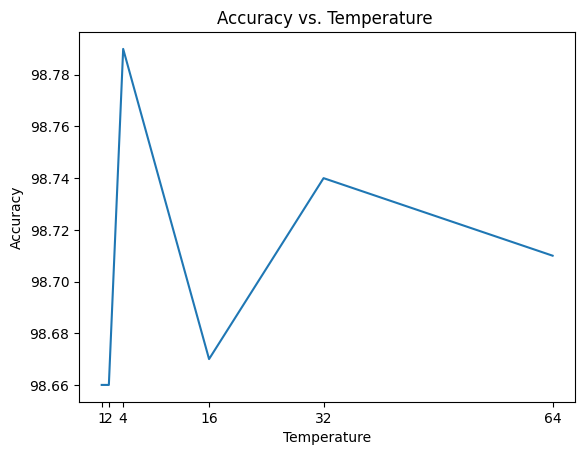

In [ ]:
# your code start from here for step 6
import matplotlib.pyplot as plt
plt.plot(temperature_set, Acc_set)

plt.xticks(temperature_set)
plt.xlabel('Temperature')
plt.ylabel('Accuracy')
plt.title('Accuracy vs. Temperature ')
plt.show()

# Train student from scratch

In [ ]:
# best hyperparameter to run

# Build fully connected student.
fc_model_no_distillation = tf.keras.Sequential()

# your code start from here for step 7
fc_model_no_distillation.add(tf.keras.layers.Flatten())
fc_model_no_distillation.add(tf.keras.layers.Dense(784,activation = 'relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(784, activation='relu'))
fc_model_no_distillation.add(tf.keras.layers.Dense(NUM_CLASSES))

#@test {"output": "ignore"}

def compute_plain_cross_entropy_loss(images, labels):
  """Compute plain loss for given images and labels.

  For fair comparison and convenience, this function also performs a
  LogSumExp over subclasses, but does not perform subclass distillation.

  Args:
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Scalar loss Tensor.
  """
  # your code start from here for step 7

  student_subclass_logits = fc_model_no_distillation(images, training=True)
  cross_entropy_loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
          labels, student_subclass_logits))

  return cross_entropy_loss


train_and_evaluate(fc_model_no_distillation, compute_plain_cross_entropy_loss)

Epoch 1: Class_accuracy: 96.73%
Epoch 2: Class_accuracy: 97.57%
Epoch 3: Class_accuracy: 97.95%
Epoch 4: Class_accuracy: 97.09%
Epoch 5: Class_accuracy: 98.05%
Epoch 6: Class_accuracy: 98.09%
Epoch 7: Class_accuracy: 98.06%
Epoch 8: Class_accuracy: 98.14%
Epoch 9: Class_accuracy: 97.90%
Epoch 10: Class_accuracy: 98.29%
Epoch 11: Class_accuracy: 97.84%
Epoch 12: Class_accuracy: 98.10%


98.1

# Comparing the teacher and student model (number of of parameters and FLOPs)

### This is the number of parameters comparison

In [ ]:

# your code start from here for step 8
print("The Teacher Model Summary:")
cnn_model.summary()
print("=======================================================")
print("The Student Model Summary:")
fc_model.summary()
print(f"The Student Model without distillation Summary:")
fc_model_no_distillation.summary()


The Teacher Model Summary:
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 25, 25, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 23, 23, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 11, 11, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 7744)              0         
                                                                 
 dropout (Dropout)         

### This is the FLOP comparing part
citation: Tokusumi (2020). flops_calculation.py.  keras_flops.https://github.com/tokusumi/keras-flops/blob/master/keras_flops/flops_calculation.py

In [ ]:

from tensorflow.python.framework.convert_to_constants import convert_variables_to_constants_v2_as_graph

def get_flops(model, batch_size=None):
    if batch_size is None:
        batch_size = 1

    # Wrap the model's call function in a tf.function
    @tf.function
    def model_forward(input_data):
        return model(input_data)

    # Get a concrete function
    real_model = model_forward.get_concrete_function(tf.TensorSpec([batch_size] + model.inputs[0].shape[1:], model.inputs[0].dtype))

    frozen_func, graph_def = convert_variables_to_constants_v2_as_graph(real_model)

    run_meta = tf.compat.v1.RunMetadata()
    opts = tf.compat.v1.profiler.ProfileOptionBuilder.float_operation()
    flops = tf.compat.v1.profiler.profile(graph=frozen_func.graph,
                                          run_meta=run_meta, cmd='op', options=opts)
    return flops.total_float_ops
print("\n=================================================")
print("==============Teacher Model==============")
print("=================================================")
model = cnn_model

flops = get_flops(model, 1)
print(f"FLOPS: {flops}")
print("\n=================================================")
print("==============Student Model==============")
print("=================================================")
model = fc_model

flops = get_flops(model, 1)
print(f"FLOPS: {flops}")
print("\n=================================================")
print("======Student Model from Scratch=======")
print("=================================================")
model = fc_model_no_distillation

flops = get_flops(fc_model_no_distillation, 1)
print(f"FLOPS: {flops}")



==============Teacher Model==============


Instructions for updating:
This API was designed for TensorFlow v1. See https://www.tensorflow.org/guide/migrate for instructions on how to migrate your code to TensorFlow v2.


FLOPS: 22042058

==============Student Model==============
FLOPS: 2475882

======Student Model from Scratch=======
FLOPS: 2475882


#Implementing the state-of-the-art KD algorithm (part a)
Choose paper of citation 15: Subclass_Knowledge_Distillation_with_Known_Subclass_Labels.pdf
using the skd

In [ ]:
import time
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], 4 * builder.info.features['label'].num_classes)
  return image, subclass_labels

def preprocess_test(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels

mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess_test).batch(BATCH_SIZE)

In [ ]:
# Build CNN teacher.
cnn_model = tf.keras.Sequential()

# your code start from here for stpe 2
cnn_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),strides=1, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2),strides = (1,1),padding='valid'),
    tf.keras.layers.Conv2D(64, (3, 3), strides=1,activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2),strides = (2,2),padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES*4)
])



# Build fully connected student.

# your code start from here for step 2
fc_model = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES*4)
])

In [ ]:
def compute_teacher_loss(images, labels, BETA=0.5, T=1.0):
    subclass_logits = cnn_model(images, training=True)

    # Compute the softmax cross-entropy loss
    cross_entropy_loss_value = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=subclass_logits)

    # Normalize the logits
    v_norm = tf.math.l2_normalize(subclass_logits, axis=1)

    # Compute the dot product matrix using matrix multiplication
    dot_product_matrix = tf.matmul(v_norm, tf.transpose(v_norm))

    # Compute the loss matrix
    loss_mat = tf.exp(dot_product_matrix / T)

    # Compute the auxiliary loss
    loss_aux = tf.reduce_mean(tf.math.log(tf.reduce_sum(loss_mat, axis=1))) - (1.0 / T) - tf.math.log(tf.cast(tf.shape(subclass_logits)[0], tf.float32))

    # Compute the final loss
    loss = cross_entropy_loss_value + BETA * loss_aux

    return loss
def distillation_loss(teacher_logits: tf.Tensor, student_logits: tf.Tensor,
                      temperature: Union[float, tf.Tensor]):
  soft_targets = tf.nn.softmax(teacher_logits / temperature)

  return tf.reduce_mean(
      tf.keras.losses.categorical_crossentropy(soft_targets, student_logits / temperature, from_logits=True)
  ) * temperature ** 2


def compute_student_loss(images, labels):
  student_subclass_logits = fc_model(images, training=True)
  teacher_subclass_logits = cnn_model(images, training=False)
  distillation_loss_value = distillation_loss(teacher_subclass_logits,student_subclass_logits,DISTILLATION_TEMPERATURE)

  # Compute cross-entropy loss with hard targets.

  # your code start from here for step 3
  cross_entropy_loss_value = tf.keras.losses.categorical_crossentropy(labels, student_subclass_logits,  from_logits=True)
  loss= ALPHA*distillation_loss_value + (1-ALPHA)* cross_entropy_loss_value
  return loss

In [ ]:
@tf.function

def compute_num_correct(model, images, labels):
  """Compute number of correctly classified images in a batch.

  Args:
    model: Instance of tf.keras.Model.
    images: Tensor representing a batch of images.
    labels: Tensor representing a batch of labels.

  Returns:
    Number of correctly classified images.
  """
  pred_labels = model(images, training=False)
  value= tf.reduce_sum(
      tf.cast(tf.math.equal(tf.argmax(pred_labels, -1), tf.argmax(labels, -1)),
              tf.float32)), tf.argmax(pred_labels, -1), tf.argmax(labels, -1)
  return value


def train_and_evaluate(model, compute_loss_fn):
  """Perform training and evaluation for a given model.

  Args:
    model: Instance of tf.keras.Model.
    compute_loss_fn: A function that computes the training loss given the
      images, and labels.
  """

  optimizer = tf.optimizers.Adam(learning_rate=0.001)
  accuracy_matrix={}
  time_matrix=[]
  for epoch in range(1, NUM_EPOCHS + 1):
    # Run training.
    start_time = time.time()
    print('Epoch {}: '.format(epoch), end='')
    for images, labels in mnist_train:
      with tf.GradientTape() as tape:
         # your code start from here for step 4
        loss_value = compute_loss_fn(images,labels)

      grads = tape.gradient(loss_value, model.trainable_variables)
      optimizer.apply_gradients(zip(grads, model.trainable_variables))

    # Run evaluation.
    num_correct = 0
    num_total = builder.info.splits['test'].num_examples
    for images, labels in mnist_test:
      num,a, b = compute_num_correct(model, images, labels)
      num_correct += num
    print("Class_accuracy: " + '{:.2f}%'.format(
        num_correct / num_total * 100))
    accuracy_matrix.update({"Student Accuracy": num_correct / num_total * 100})
    epoch_time = time.time() - start_time
    time_matrix.append(epoch_time)
    print("Total time per epoch: {0:.2f} seconds".format(epoch_time))
  total_time = np.sum(time_matrix)
  print("Total time of training this model: {0:.2f} seconds".format(total_time))

  return accuracy_matrix


In [ ]:
ALPHA = 0.5
BETA = 0.5
DISTILLATION_TEMPERATURE = 4
NUM_EPOCHS = 12

In [ ]:
teatherrun= train_and_evaluate(cnn_model, compute_teacher_loss)

Epoch 1: Class_accuracy: 97.86%
Total time per epoch: 12.90 seconds
Epoch 2: Class_accuracy: 98.57%
Total time per epoch: 9.06 seconds
Epoch 3: Class_accuracy: 98.78%
Total time per epoch: 10.55 seconds
Epoch 4: Class_accuracy: 98.86%
Total time per epoch: 10.57 seconds
Epoch 5: Class_accuracy: 98.91%
Total time per epoch: 8.28 seconds
Epoch 6: Class_accuracy: 99.01%
Total time per epoch: 9.54 seconds
Epoch 7: Class_accuracy: 99.11%
Total time per epoch: 9.23 seconds
Epoch 8: Class_accuracy: 98.97%
Total time per epoch: 9.09 seconds
Epoch 9: Class_accuracy: 99.10%
Total time per epoch: 8.43 seconds
Epoch 10: Class_accuracy: 99.13%
Total time per epoch: 9.68 seconds
Epoch 11: Class_accuracy: 99.11%
Total time per epoch: 9.12 seconds
Epoch 12: Class_accuracy: 99.15%
Total time per epoch: 8.99 seconds
Total time of training this model: 115.44 seconds


In [ ]:
studentrun = train_and_evaluate(fc_model, compute_student_loss)

Epoch 1: Class_accuracy: 98.46%
Total time per epoch: 8.96 seconds
Epoch 2: Class_accuracy: 98.54%
Total time per epoch: 9.41 seconds
Epoch 3: Class_accuracy: 98.63%
Total time per epoch: 9.07 seconds
Epoch 4: Class_accuracy: 98.70%
Total time per epoch: 9.14 seconds
Epoch 5: Class_accuracy: 98.69%
Total time per epoch: 8.05 seconds
Epoch 6: Class_accuracy: 98.80%
Total time per epoch: 8.86 seconds
Epoch 7: Class_accuracy: 98.79%
Total time per epoch: 8.90 seconds
Epoch 8: Class_accuracy: 98.79%
Total time per epoch: 10.54 seconds
Epoch 9: Class_accuracy: 98.79%
Total time per epoch: 8.50 seconds
Epoch 10: Class_accuracy: 98.82%
Total time per epoch: 9.41 seconds
Epoch 11: Class_accuracy: 98.83%
Total time per epoch: 9.03 seconds
Epoch 12: Class_accuracy: 98.82%
Total time per epoch: 8.93 seconds
Total time of training this model: 108.80 seconds


# Implementing the state-of-the-art KD algorithm (part b)
Choose to read the paper with citation 9:
Seyed Iman Mirzadeh, Mehrdad Farajtabar, Ang Li, Nir Levine, Akihiro Matsukawa, and Hassan Ghasemzadeh. Improved knowledge distillation via teacher assistant. In Proceedings of the AAAI Conference on Artificial Intelligence, volume 34, pages 5191–5198, 2020

In [ ]:
# your code start from here for step 12
import time
import numpy as np
import tensorflow_datasets as tfds

def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels

def preprocess_test(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels

mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess_test).batch(BATCH_SIZE)

Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]

Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


In [ ]:
# Teacher model
cnn_model_takd = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),strides=1, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2),strides = (1,1),padding='valid'),
    tf.keras.layers.Conv2D(64, (3, 3), strides=1,activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2),strides = (2,2),padding='valid'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(NUM_CLASSES)
])

#TA Model
ta_model_takd = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3),strides=1, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D((2, 2),strides = (1,1),padding='valid'),
    tf.keras.layers.Conv2D(63, (3, 3),strides=1, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES)
])

#Student Model
fc_model_takd = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES)
])

In [ ]:
#Teacher Loss
import torch
import torch.nn as nn
import torch.nn.functional as F

def compute_teacher_loss_takd(images, labels):

    subclass_logits = cnn_model_takd(images, training=True)

    # # Compute the softmax cross-entropy loss
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,subclass_logits))

    return loss

In [ ]:
#TA Loss
def kl_loss(student_logits, teacher_logits, T):

  soft_targets = tf.nn.softmax(teacher_logits / T, axis=1)

  return tf.reduce_mean(
      tf.nn.softmax_cross_entropy_with_logits(
          soft_targets, student_logits / T)) * T ** 2



def compute_ta_loss_takd(images, labels, lamb=0.5, T=4):
    teacher_logits = cnn_model_takd(images, training=False)
    ta_logits = ta_model_takd(images, training = True)

    L_kl = kl_loss(ta_logits, teacher_logits, T)
    L_ce =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,ta_logits))
    loss =  (1 - lamb) * L_ce + lamb * L_kl
    return loss

In [ ]:
#Student Loss
def compute_student_loss_takd(images, labels, lamb=0.5, T=4):
    ta_logits = ta_model_takd(images, training=False)
    student_logits = fc_model_takd(images, training = True)

    L_kl = kl_loss(student_logits, ta_logits, T)
    L_ce =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_logits))
    loss = (1 - lamb) * L_ce + lamb * L_kl
    return loss


In [ ]:
print('Start training TEACHER model')
test_acc_teacher = train_and_evaluate(cnn_model_takd, compute_teacher_loss_takd)
print('Start training TA model')
test_acc_ta = train_and_evaluate(ta_model_takd, compute_ta_loss_takd)
print('Start training student model')
test_acc_student = train_and_evaluate(fc_model_takd, compute_student_loss_takd)

Start training TEACHER model
Epoch 1: Class_accuracy: 98.09%
Epoch 2: Class_accuracy: 98.64%
Epoch 3: Class_accuracy: 98.85%
Epoch 4: Class_accuracy: 98.83%
Epoch 5: Class_accuracy: 99.04%
Epoch 6: Class_accuracy: 99.13%
Epoch 7: Class_accuracy: 99.05%
Epoch 8: Class_accuracy: 99.06%
Epoch 9: Class_accuracy: 99.18%
Epoch 10: Class_accuracy: 99.15%
Epoch 11: Class_accuracy: 99.18%
Epoch 12: Class_accuracy: 99.27%
Start training TA model
Epoch 1: Class_accuracy: 98.72%
Epoch 2: Class_accuracy: 99.08%
Epoch 3: Class_accuracy: 99.07%
Epoch 4: Class_accuracy: 99.19%
Epoch 5: Class_accuracy: 99.21%
Epoch 6: Class_accuracy: 99.20%
Epoch 7: Class_accuracy: 99.20%
Epoch 8: Class_accuracy: 99.18%
Epoch 9: Class_accuracy: 99.22%
Epoch 10: Class_accuracy: 99.17%
Epoch 11: Class_accuracy: 99.21%
Epoch 12: Class_accuracy: 99.13%
Start training student model
Epoch 1: Class_accuracy: 96.68%
Epoch 2: Class_accuracy: 97.76%
Epoch 3: Class_accuracy: 98.27%
Epoch 4: Class_accuracy: 98.44%
Epoch 5: Class_a

In [ ]:
fc_model_nokd = tf.keras.Sequential([
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(784, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES)
])

def csl(images, labels, lamb=0.5, T=4):
    ta_logits = cnn_model_takd(images, training=False)
    student_logits = fc_model_nokd(images, training = True)

    L_kl = kl_loss(student_logits, ta_logits, T)
    L_ce =  tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels,student_logits))
    loss = (1 - lamb) * L_ce + lamb * L_kl
    return loss


In [ ]:
print('Start training student model')
test_acc_student = train_and_evaluate(fc_model_nokd, csl)

Start training student model
Epoch 1: Class_accuracy: 97.04%
Epoch 2: Class_accuracy: 97.77%
Epoch 3: Class_accuracy: 98.16%
Epoch 4: Class_accuracy: 98.40%
Epoch 5: Class_accuracy: 98.49%
Epoch 6: Class_accuracy: 98.63%
Epoch 7: Class_accuracy: 98.68%
Epoch 8: Class_accuracy: 98.67%
Epoch 9: Class_accuracy: 98.63%
Epoch 10: Class_accuracy: 98.67%
Epoch 11: Class_accuracy: 98.69%
Epoch 12: Class_accuracy: 98.70%


# XAI method to explain models
ciation: Mohammadi, Seyedmahmoud. "xai_utils.py." ECE1512_2022W_ProjectRepo, GitHub, 2023, https://github.com/RezaMohammadi99/ECE1512_2022W_ProjectRepo_Seyedmahmoud-Mohammadi/blob/main/Project_A/xai_utils.py.


In [ ]:
"""
Reference:
Mohammadi, Seyedmahmoud. "xai_utils.py." ECE1512_2022W_ProjectRepo, GitHub, 2023,
https://github.com/RezaMohammadi99/ECE1512_2022W_ProjectRepo_Seyedmahmoud-Mohammadi/blob/main/Project_A/xai_utils.py.
"""
import tensorflow.compat.v2 as tf
import tensorflow_datasets as tfds
from typing import Union

tf.enable_v2_behavior()

builder = tfds.builder('mnist')
BATCH_SIZE = 256
NUM_EPOCHS = 12
NUM_CLASSES = 10  # 10 total classes.

# Load train and test splits.
def preprocess(x):
  image = tf.image.convert_image_dtype(x['image'], tf.float32)
  subclass_labels = tf.one_hot(x['label'], builder.info.features['label'].num_classes)
  return image, subclass_labels


mnist_train = tfds.load('mnist', split='train', shuffle_files=False).cache()
mnist_train = mnist_train.map(preprocess)
mnist_train = mnist_train.shuffle(builder.info.splits['train'].num_examples)
mnist_train = mnist_train.batch(BATCH_SIZE, drop_remainder=True)

mnist_test = tfds.load('mnist', split='test').cache()
mnist_test = mnist_test.map(preprocess).batch(BATCH_SIZE)



In [ ]:
import cv2
from time import time
import os
import numpy as np
import json

import tensorflow as tf
from tensorflow import keras
from scipy.ndimage.interpolation import zoom
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow.keras.backend as K
from PIL import Image, ImageDraw

import matplotlib.pyplot as plt
#############################

def layer_finder(k_model, model_arch, pool_input=True):

  '''
  Returns a list of all of the last layers in each block of the model.

    Parameters:
      k_model (Keras model): Either a VGG or ResNet
      model_arch (str): Either "VGG" or "ResNet"

    Returns:
      last_layers (list): A list of all of the last layers in each block of the
      model.
  '''

  if type(model_arch) != str:
    raise TypeError("Input argument \"model_arch\" must be a string that is\
                      either \"VGG\" or \"ResNet\".")

  last_layers = []
  pool_flag=False
  block_end_detected=False
  first_layer=True
  j=0

  if model_arch == "VGG":

    for layer in k_model.layers:
      if type(layer) == tf.keras.layers.MaxPool2D:
        last_layers.append(layer.name)

  elif model_arch == "ResNet":


    for i in range(len(k_model.layers)):
      if i<j: continue
      #print(k_model.layers[i])
      if len(k_model.layers[i+1].output.get_shape()) < 4:
        # only save a layer if the block before the end was a convolutional block
            last_layers.append(k_model.layers[i].name)
            break

      if k_model.layers[i+1].output.get_shape()[2]<k_model.layers[i].output.get_shape()[2]-4:
          if pool_input==True:
              if type(k_model.layers[i]) == tf.keras.layers.InputLayer: continue
              if 'ZeroPadding2D' in str(type(k_model.layers[i])):
                  if type(k_model.layers[i-1]) == tf.keras.layers.InputLayer: continue
                  last_layers.append(k_model.layers[i-1].name)
              else:
                  last_layers.append(k_model.layers[i].name)
          else:
              if first_layer:
                  j=i+1
                  pool_flag=True
                  while(pool_flag):
                      j += 1
                      #print(str(type(k_model.layers[j])))
                      if  'Conv2D' in str(type(k_model.layers[j])):
                          #print('Here')
                          last_layers.append(k_model.layers[j-1].name)
                          first_layer=False
                          pool_flag=False
              else:
                  j=i
                  pool_flag=True
                  while(pool_flag):
                      j += 1
                      #print(str(type(k_model.layers[j])))
                      if 'merge.Add' in str(type(k_model.layers[j])):
                          block_end_detected=True
                          #print(j)
                      elif block_end_detected==True and 'Conv2D' in str(type(k_model.layers[j])):
                          #print('Here')
                          last_layers.append(k_model.layers[j-1].name)
                          block_end_detected=False
                          pool_flag=False
  else:

    print("Input argument \"model_arch\" must be either \"VGG\" or \"ResNet\".")

  return [[lay] for lay in last_layers]
def create_random_mask(h=7, w=7, H=224, W=224, p_1=0.5, resample=Image.BILINEAR):
    '''
    Generates one random mask utilized in RISE
    inputs:
        h, w: initial size of binary mask
        H, W: final size of the upsampled mask
        p_1: probability of actiating pixels in the down-sampled masks.
        interp: upsampling technique.
    returns:
        mask: a smooth mask with the values in range [0,1] with size of HxW.
    '''
    assert H>h, 'Masks should be resized to higher dimensions.'
    assert W>w, 'Masks should be resized to higher dimensions.'
    # create random binary hxw mask
    mask=np.random.choice([0, 1], size=(h, w), p=[1-p_1, p_1])

    # upsample mask to (h+H,w+W)
    mask = Image.fromarray(mask*255.)
    mask = mask.resize((H + h, W + w), resample=resample)
    mask = np.array(mask)

    # randomly crop mask to HxW
    w_crop = np.random.randint(0,w+1)
    h_crop = np.random.randint(0,h+1)
    mask = mask[h_crop:H + h_crop, w_crop:W + w_crop]

    # normalize between 0 and 1
    mask /= np.max(mask)

    return mask

def create_attribution_masks(img, model, layers, class_index, max_mask_num, interp='bilinear'):
    '''
    Derives feature maps from one, or a couple of layers, and post-processes them
    to convert them to attribution masks.

    inputs:
        img: a 4-D tensor image.
        model: the classification model
        layers: list of layers to be visualized either individually or mutually.
        class_index: the output class according to whom the layer(s) are visualized.
        max_mask_num: the threshold "normalized gradient" value for sampling attribution masks (\mu in our paper)
        interp: upsampling technique.
        For now, 'bilinear' and 'nearest' are supported.
    returns:
        masks: a set of attribution masks normalized between 0 and 1.
    '''
    assert interp in ['bilinear', 'nearest'], 'Selected upsampling type undefined or unsupported.'
    # Forward pass to get attribution masks.
    conv_outputs=[]
    for layer in model.layers:
        if np.isin(layer.name,layers):
            conv_outputs.append(layer.output)
    conv_outputs.append(model.output)
    feedforward1=keras.models.Model([model.input], [conv_outputs])
    with tf.GradientTape() as tape:
        ff_results=feedforward1([img])[0]
        all_fmap_masks, predictions = ff_results[:-1], ff_results[-1]
        loss = predictions[:, class_index]
    grads = tape.gradient(loss, all_fmap_masks)
    ###

    # upsample and normalize masks.
    num_masks=0
    masks=[]
    for i in range(len(layers)):
        tmp_mask = all_fmap_masks[i][0].numpy()
        if len(img.shape)==3:
            axis=0
            size=img.shape[1:]
            tmp_mask = np.expand_dims(tmp_mask, axis=1)
        elif len(img.shape)==4:
            axis=(0,1)
            size=img.shape[1:-1]
        significance = np.mean(grads[i][0], axis=axis)
        #idxs = np.argpartition(significance, -1*max_mask_num)[-1*max_mask_num:]
        idxs = np.where(significance>max_mask_num*np.max(significance))[0]
        if interp == 'bilinear':
            fmap = tf.image.resize(tmp_mask[...,idxs], size, method='bilinear').numpy()
        elif interp == 'nearest':
            fmap = tf.image.resize(tmp_mask[...,idxs], size, method='nearest').numpy()
        else: raise ValueError('You have selected an unsupported interpolation type.')

        num_masks+=fmap.shape[2]
        fmap -= np.min(fmap, axis=(0,1))
        fmap /= (np.max(fmap, axis=(0,1))+10e-7)
        masks.append(fmap)
    return masks

def visualize_layers(img, model, class_index, masks, H=224, W=224, C=3, batch_size = 128):
    '''
    Combines attribution masks using the RISE-based framework mentioned in
    SISE white paper.
    inputs:
        img: a 3-D tensor image.
        model: the classification model
        class_index: the output class according to whom the layer(s) are visualized.
        masks: a set of attribution masks normalized between 0 and 1.
    returns:
        sum_masks: visualization map of the selected layer(s).
    This function follows 'create_attribution_masks()'.
    '''
    # creates perturbed images to probe model.
    img = img if len(img.shape)==3 else np.expand_dims(img, axis=1)
    X = np.einsum('hwc,hwn->nhwc', img, masks)
    # second forward pass to valuate attribution maps
    preds_masked = np.empty([0])
    if masks.shape[2] <= batch_size :
      preds_masked=np.append(preds_masked, model(X, training=False)[:,class_index],axis=0)
    else :
      for i in range (0, masks.shape[2]-batch_size, batch_size) :
        preds_masked=np.append(preds_masked, model(X[i:i+batch_size], training=False)[:,class_index],axis=0)
      preds_masked=np.append(preds_masked, model(X[i+batch_size:], training=False)[:,class_index],axis=0)

    # Linear combination of attribution masks.
    masks /= (masks.sum(axis=(0,1))+10e-7)
    sum_mask = np.einsum('hwn,n->hw', masks, preds_masked)

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

def otsu(I, nbins=256, tau=1.5):
    '''
    Finds the optimum adaptive threshold value for a 2-D image.
    inputs:
        I: a 2-D image (visualization map/ heat-map/ etc.)
        nbins: resolution of histogram. Increasing this parameter yields to more
        precise threshold value, achieved in longer time.
        tau: bottleneck amplititude
        returns: Otsu adaptive threshold value
    '''
    I = np.round(I*nbins)
    #histogram of the image
    hist, bins = np.histogram(I.ravel(),nbins,[0,nbins])
    #CDF/ mean/ variance terms for multiple values
    i = np.arange(nbins)
    varsb = np.zeros(nbins)
    for j in range(1, nbins):
        w0 = np.sum(hist[0:j])
        w1 = np.sum(hist[j:nbins])
        u0 = np.sum(np.multiply(hist[0:j], i[0:j])) / w0
        u1 = np.sum(np.multiply(hist[j:nbins], i[j:nbins])) / w1
        varsb[j] = w0 * w1 * (u0-u1) * (u0-u1)
    # the threshold value is the one maximizing the variance term.
    t = np.argmax(varsb)
    #print(t)
    k = round(t*tau)
    if np.sum(hist[int(k):256]) < .1 * np.sum(hist):
        #print('happened')
        return t*tau/nbins
    else:
        return t/nbins

def otsu_sigmoid(I, nbins=256, T=100., tau=1.5):
    '''
        Thresholds the 2-D visualization map softly, combining Otsu's method and
        sigmoid function.
        inputs:
            I: a 2-D image (visualization map/ heat-map/ etc.)
            nbins: resolution of histogram. Increasing this parameter yields to more
            precise threshold value, achieved in longer time.
            T: sigmoid temparature (preferred to be set to high values.)
        returns:
            the soft-thresholded heat-map according to the input.
    '''
    thr=otsu(I, nbins=256, tau=1.5)
    return 1/(1 + np.exp(-(I-thr)*T))

def fuse_visualization_maps(exmaps, fusion_type='otsu', T=100.):
    '''
    Fuses visualization maps to a unique explanation map. Visualization maps should
    be given with the correct order (low-level layer to high-level layer)

    '''
    assert fusion_type in ['simple', 'otsu']
    ex=exmaps[0]
    if fusion_type=='simple':
        for i in range(1, len(exmaps)):
            ex += exmaps[i]
            ex *= exmaps[i]
    elif fusion_type=='otsu':
        for i in range(1, len(exmaps)):
            ex += exmaps[i]
            ex *= otsu_sigmoid(exmaps[i], T=T)
    return ex

def SISE(img, model, class_index, layers, grad_thr, interp='bilinear',
         fusion_type='otsu', T=100.):

    '''
    For now, this function supports VGG16, ResNet50, and ResNet101.
    img: a 4-D image, or a 3-D array.
    model: the classification model
    layers: list of layers to be visualized either individually or mutually.
    interp: upsampling technique.
    Check the supproted upsampling types in function 'create_attribution_masks'.
	grad_thr: Threshold on the average gradient values to select the most appropriate feature maps.
    fusion_type: the fusion technipue for visualization maps:
        simple: Using only addition and multiplication blocks.
        otsu: Using addition, soft otsu threshold, and multiplication blocks.
    auto_layer_finder: if 'True', the layers are automatically selected. Otherwise,
        pre-defined layers for the models experimented are used.
    pool_input_select: If True, the inputs of pooling layers are detected automatically.
        Otherwise,  the outputs of pooling layers are detected automatically.
        If 'auto_layer_finder=False', this parameter is ineffective.
    '''
    masks = create_attribution_masks(img, model, layers, class_index=class_index, max_mask_num = grad_thr, interp=interp)
    exmaps=[]
    for mask_set in masks:
        exmaps.append(visualize_layers(img[0], model, class_index, mask_set))
    return fuse_visualization_maps(exmaps, fusion_type=fusion_type, T=T)


def weighted_fusion(w,exmaps, T=100.):
    '''
    Objective: weighted fusion using weighted addition, unweighted multiplication, and otsu threshold blocks.
    inputs:
        w: an array of weight factors of length N-1.
        exmaps: a 3-D array of explanation maps of length H x W x N.
    parameters:
        N: number of visualiation maps received
        H x W: size of visualization maps.
    outputs:
        e_out: fused explanation map.
    '''
    #w_post=np.maximum(w,0)
    w_post=np.clip(a=w, a_min=0, a_max=2)
    e23=np.multiply((exmaps[:,:,0]*w_post[0]+exmaps[:,:,1]*(2-w_post[0])),
                    otsu_sigmoid(exmaps[:,:,1], T=T))
    e234=np.multiply((e23*w_post[1]+exmaps[:,:,2]*(2-w_post[1])),
                    otsu_sigmoid(exmaps[:,:,2], T=T))
    e2345=np.multiply((e234*w_post[2]+exmaps[:,:,3]*(2-w_post[2])),
                    otsu_sigmoid(exmaps[:,:,3], T=T))
    e23456=np.multiply((e2345*w_post[3]+exmaps[:,:,4]*(2-w_post[3])),
                    otsu_sigmoid(exmaps[:,:,4], T=T))
    e_out = e23456
    return e_out

def grad_cam(input_model, image, layer_name):
    cls = np.argmax(input_model.predict(image))
    def normalize(x):
        """Utility function to normalize a tensor by its L2 norm"""
        return (x + 1e-10) / (K.sqrt(K.mean(K.square(x))) + 1e-10)
    """GradCAM method for visualizing input saliency."""
    y_c = input_model.output
    conv_output = input_model.get_layer(layer_name).output
    feedforward1 = keras.models.Model([input_model.input], [conv_output, y_c])
    with tf.GradientTape() as tape:
        ff_results=feedforward1([image])
        all_fmap_masks, predictions = ff_results[0], ff_results[-1]
        loss = predictions[:, cls]
    grads_val = tape.gradient(loss, all_fmap_masks)
    if len(image.shape)==3:
        axis=(0, 1)
    elif len(image.shape)==4:
        axis=(0, 1, 2)
    weights = np.mean(grads_val, axis=axis)
    cam = np.dot(all_fmap_masks[0], weights)
    H,W= image.shape[1:3]
    cam = np.maximum(cam, 0)
    cam = zoom(cam,H/cam.shape[0])
    cam = cam / cam.max()
    return cam

def RISE(img, model, class_index, N_MASKS=8000, H=224, W=224, C=3):
    '''
	img: a 3-D input image
	model: a trained model
	class_index; The class of interest
	N_MASKS: The number of random masks to be generated
	H,W,C: The desired dimensions of the random masks
	'''
    X = np.zeros(shape=(N_MASKS, H, W, C), dtype=np.float32)
    masks = np.zeros((N_MASKS,H,W), dtype=np.float32)
    #for i in tqdm(range(N_MASKS)):
    for i in range(N_MASKS):
        m =create_random_mask(H=H, W=W)
        masks[i] = m
        x = img.copy()

        x[:, :, 0] *= m
        #x[:, :, 1] *= m
        #x[:, :, 2] *= m
        X[i] = x
    preds_masked = model.predict(X, verbose=0)
    sum_mask = np.zeros(masks[0].shape, dtype=np.float32)

    # np.einsum???
    for i, mask in enumerate(masks):
        m = mask * preds_masked[i, class_index]
        sum_mask += m

    sum_mask -= np.min(sum_mask)
    sum_mask /= np.max(sum_mask)
    return sum_mask

<ipython-input-9-9dd273b1fbe7>:9: DeprecationWarning: Please use `zoom` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import zoom


8/8 [==============================] - 0s 2ms/step


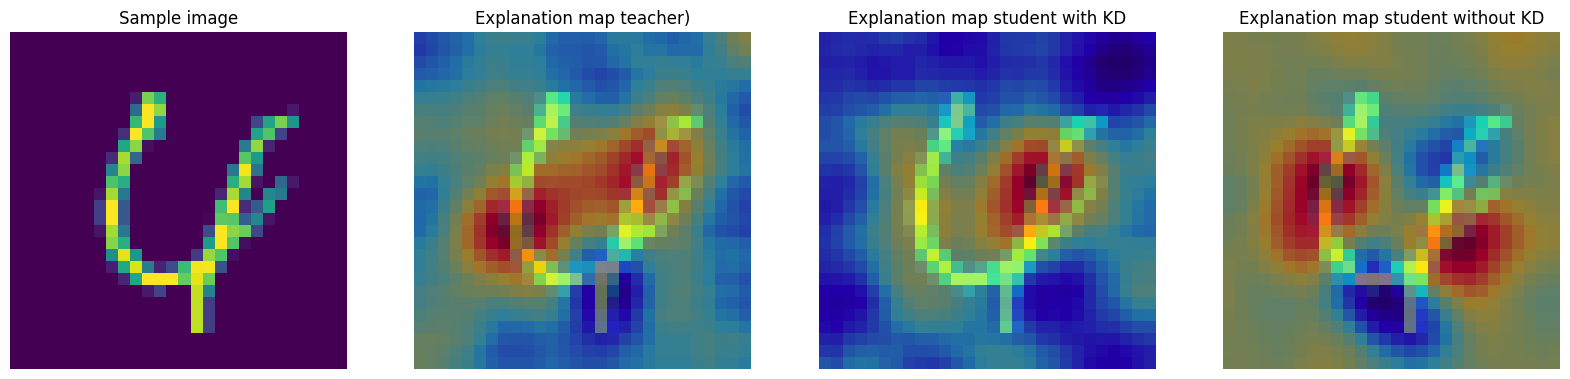

1
8/8 [==============================] - 0s 2ms/step


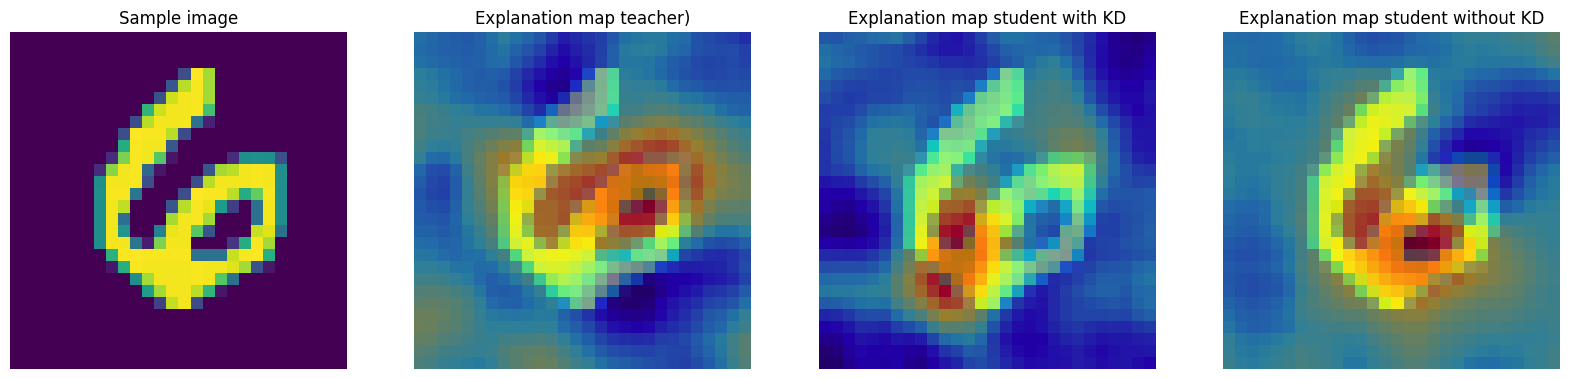

2
8/8 [==============================] - 0s 2ms/step


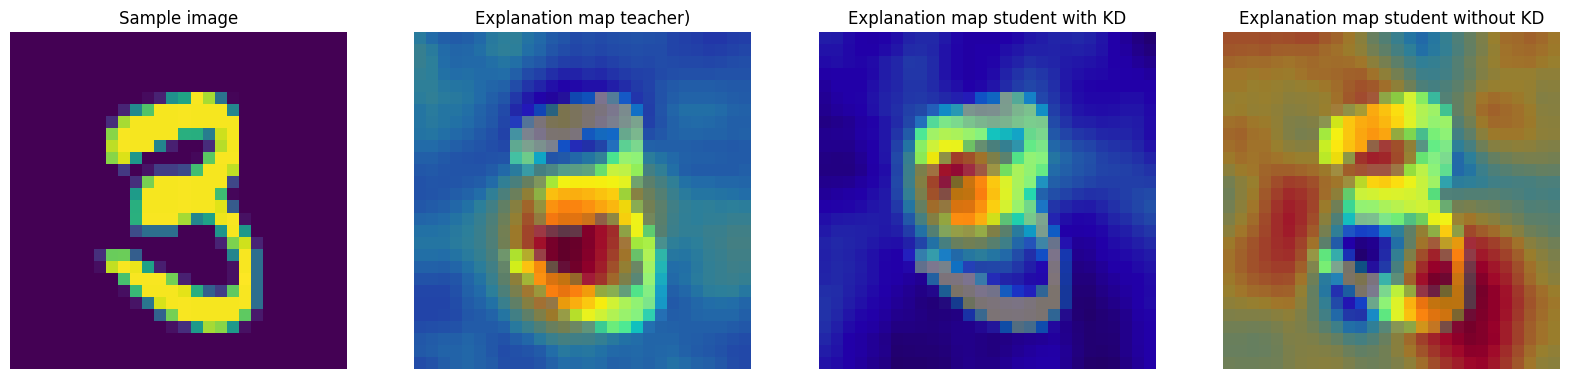

3
8/8 [==============================] - 0s 2ms/step


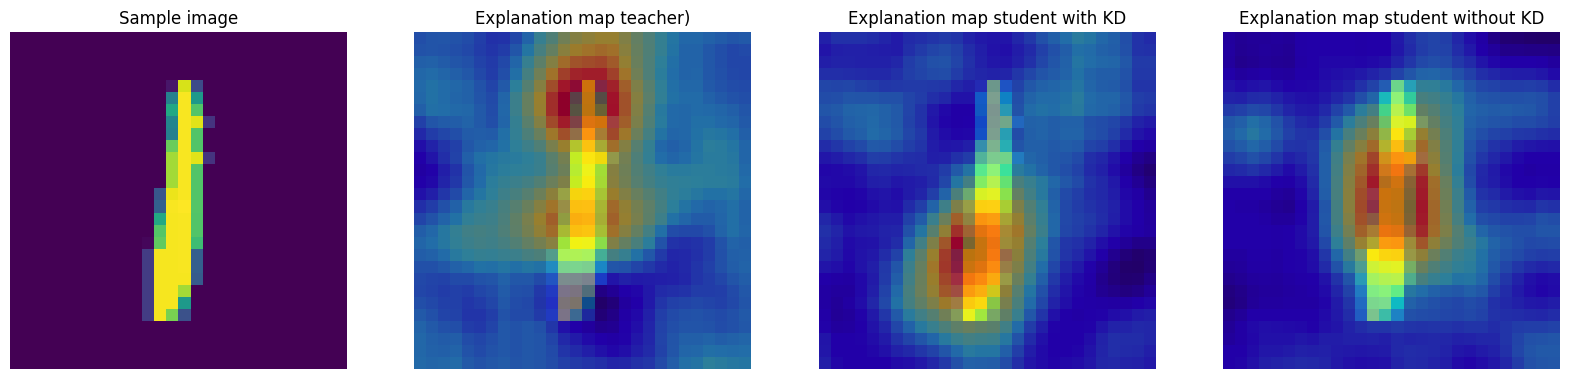

4
8/8 [==============================] - 0s 2ms/step


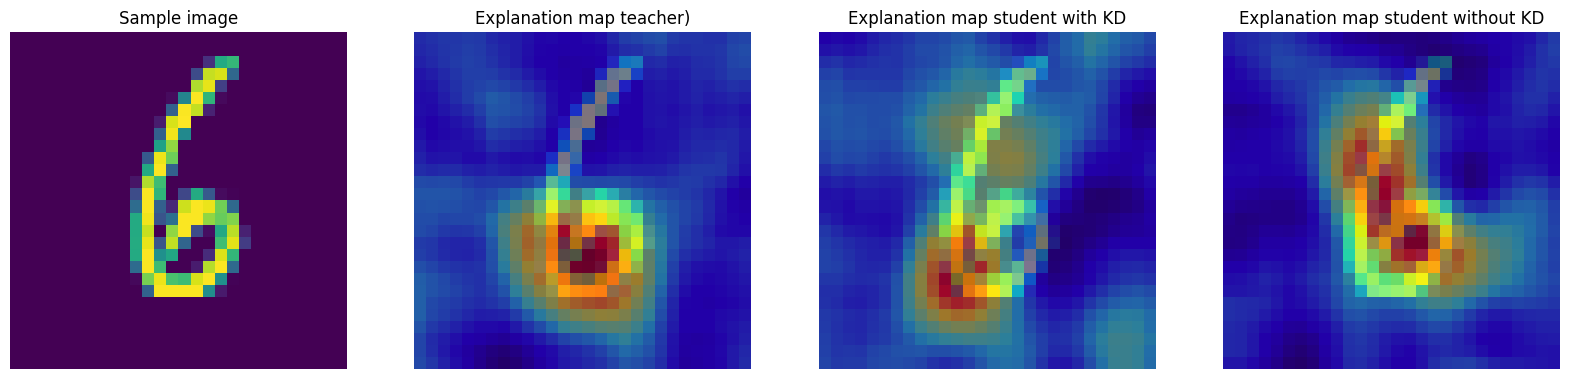

5
8/8 [==============================] - 0s 2ms/step


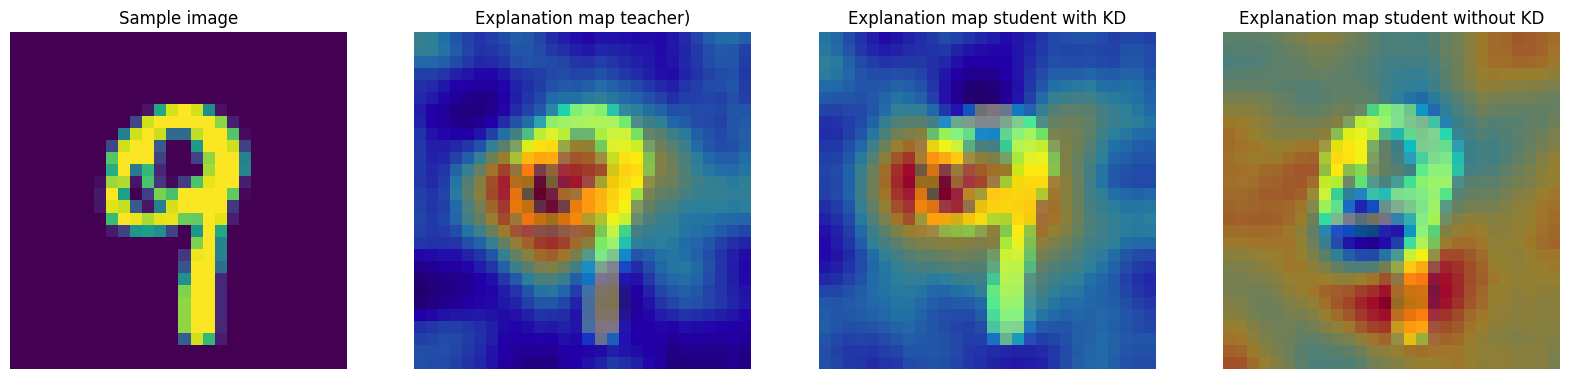

6
8/8 [==============================] - 0s 2ms/step


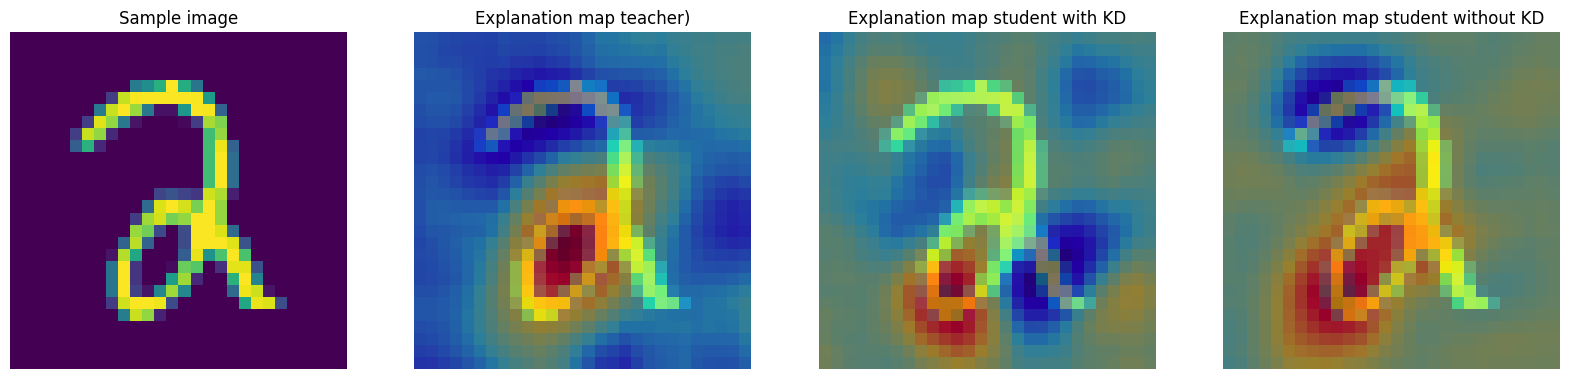

7
8/8 [==============================] - 0s 2ms/step


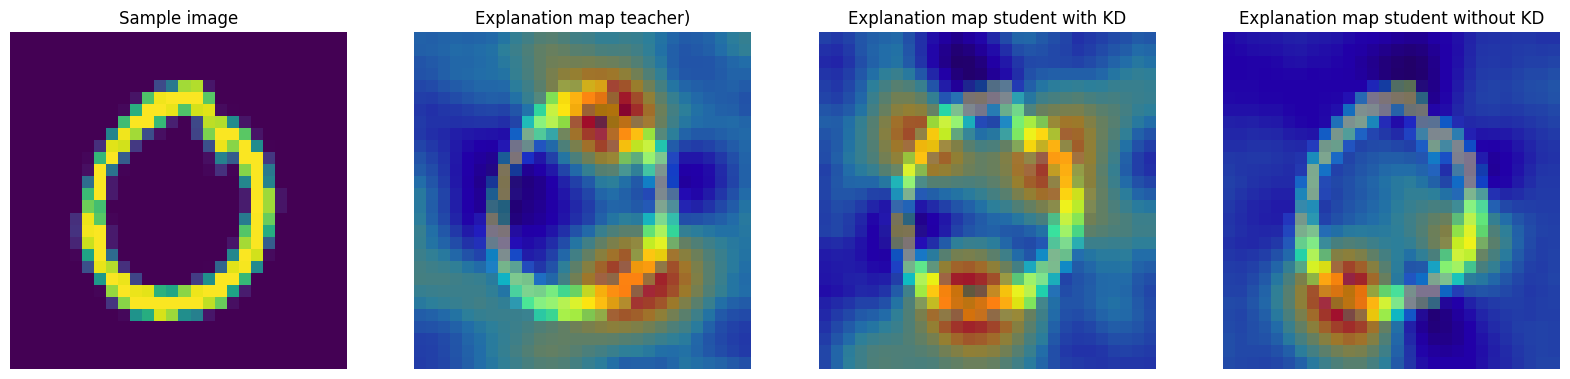

8
8/8 [==============================] - 0s 2ms/step


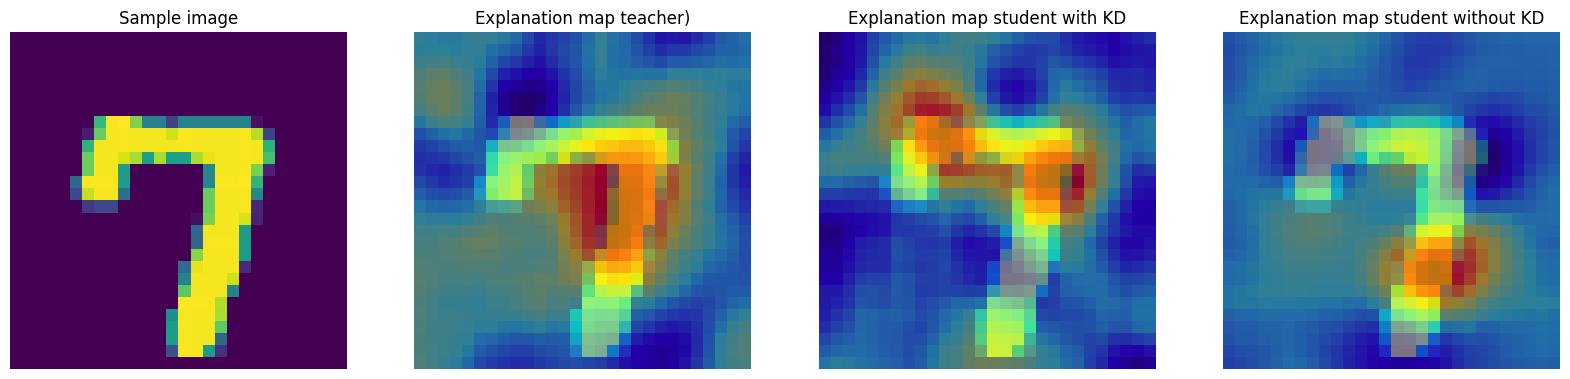

9
8/8 [==============================] - 0s 2ms/step


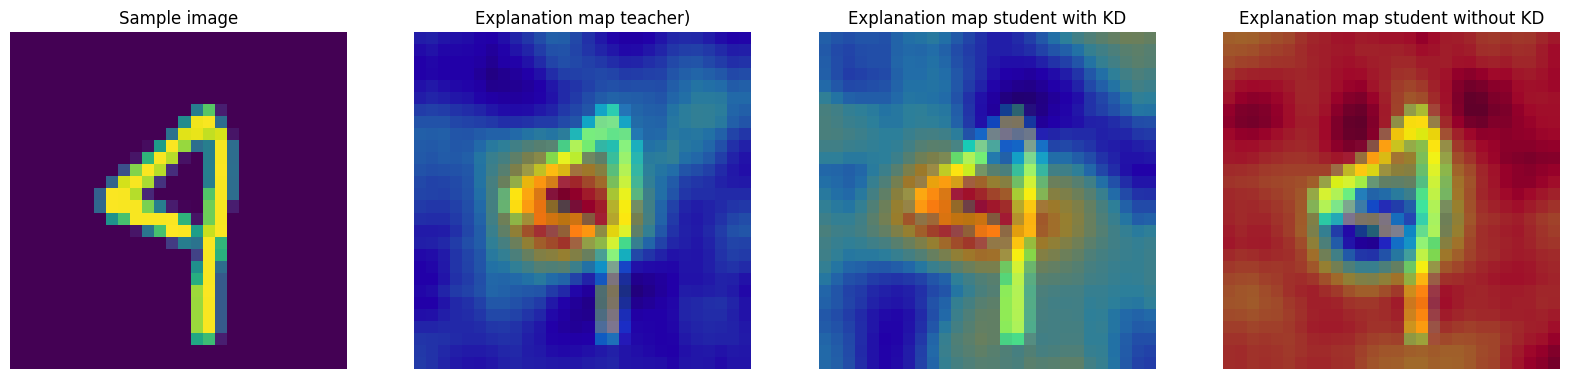

10


In [ ]:

k = 0
index = 70
for next_batch in mnist_train:
    #print(np.array(next_batch[0]).shape)   #image
    image_batch = next_batch[0]
    prediction_teacher = cnn_model.predict(image_batch)
    prediction_student = fc_model.predict(image_batch)
    label = next_batch[1]
    #print(np.array(next_batch[1]).shape)   #label

    img = np.array(image_batch[index])

    explanation_map_RISE1 = RISE(img, cnn_model, class_index=np.argmax(prediction_teacher[index]) ,N_MASKS=1000,H=28, W=28, C=1)  #
    explanation_map_RISE1 -= explanation_map_RISE1.min()
    explanation_map_RISE1 /= explanation_map_RISE1.max()+10e-30

    explanation_map_RISE2 = RISE(img, fc_model, class_index=np.argmax(prediction_student[index]) ,N_MASKS=1000,H=28, W=28, C=1)
    explanation_map_RISE2 -= explanation_map_RISE2.min()
    explanation_map_RISE2 /= explanation_map_RISE2.max()+10e-30

    explanation_map_RISE3 = RISE(img, fc_model_no_distillation, class_index=np.argmax(prediction_student[index]) ,N_MASKS=1000,H=28, W=28, C=1)
    explanation_map_RISE3 -= explanation_map_RISE3.min()
    explanation_map_RISE3 /= explanation_map_RISE3.max()+10e-30

    plt.figure(figsize=(20,5))
    plt.subplot(1,4,1)
    plt.imshow(img[:,:,0])
    plt.axis('off')
    plt.title('Sample image')

    plt.subplot(1,4,2)
    plt.imshow(img[:,:,0])
    plt.imshow(explanation_map_RISE1, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map teacher)')

    plt.subplot(1,4,3)
    plt.imshow(img[:,:,0])
    plt.imshow(explanation_map_RISE2, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map student with KD')

    plt.subplot(1,4,4)
    plt.imshow(img[:,:,0])
    plt.imshow(explanation_map_RISE3, cmap='jet', alpha=0.5)
    plt.axis('off')
    plt.title('Explanation map student without KD')
    plt.show()

    k += 1
    print(k)
    if k == 10:
      break
